# Topic modeling the Russian Troll Tweets dataset
----
#### By John West

We'll start by importing the data from the CSVs.

In [4]:
import csv
import glob

file_names = []
for file_name in glob.glob('russian-troll-tweets/*.csv'):
    file_names.append(file_name)
sorted_file_names = sorted(file_names)

all_tweets = []
header_row = []
for file_name in sorted_file_names:
    with open(file_name, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        first = True
        for row in csv_reader:
            if first == True:
                header_row = row
                first = False
            else:
                all_tweets.append(row)

In [5]:
import datetime
election_day_datetime = datetime.datetime(2016, 11, 8)
tweets = []
for t in all_tweets:
    date_array = t[5].split(' ')[0].split('/')
    year = int(date_array[2])
    month = int(date_array[0])
    day = int(date_array[1])
    if t[4] == 'English' and datetime.datetime(year, month, day) <= election_day_datetime:
        tweets.append(t)

In [6]:
account_types = {}
for tweet in tweets:
    try:
        account_types[tweet[14].lower()]
    except KeyError:
        account_types[tweet[14].lower()] = []
    account_types[tweet[14].lower()].append(tweet)
unsorted_account_types_meta = []
for key in account_types.keys():
    unsorted_account_types_meta.append([key, len(account_types[key])])
account_types_meta = sorted(unsorted_account_types_meta, key=lambda item: item[1])
account_types_meta.reverse()
for meta in account_types_meta:
    print(meta)

['newsfeed', 406052]
['righttroll', 270832]
['lefttroll', 186219]
['hashtaggamer', 162077]
['commercial', 112919]
['nonenglish', 11236]
['fearmonger', 10998]
['unknown', 6563]


In [7]:
authors_dict = {}
for tweet in tweets:
    try:
        authors_dict[tweet[0]]
    except KeyError:
        authors_dict[tweet[0]] = {'author_handle': tweet[1], 'account_type': tweet[14], 'tweet_bodies': []}
    authors_dict[tweet[0]]['tweet_bodies'].append(tweet[2])
authors = []
for author_id, author_data in authors_dict.items():
    authors.append({
        'account_type': author_data['account_type'],
        'author_handle': author_data['author_handle'],
        'external_author_id': author_id,
        'tweet_bodies': author_data['tweet_bodies'],
        'tweets_count': len(author_data['tweet_bodies'])
    })

In [68]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
import logging
import re

class TaggedDocumentIterator:
    def __iter__(self):
        for i, author in enumerate(authors):
            tweets_text = ''
            for tweet_text in author['tweet_bodies']:
                scrubbed_tweet_text = re.sub(r'\bhttps://t\.co/\S*\b', '', tweet_text)
                tweets_text = tweets_text + ' ' + scrubbed_tweet_text
            yield TaggedDocument(simple_preprocess(tweets_text), [i])

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

corpus = TaggedDocumentIterator()

model = Doc2Vec(vector_size=200, min_count=5, epochs=10, workers=3)
model.build_vocab(corpus)

2018-08-01 14:48:59,863 : INFO : collecting all words and their counts
2018-08-01 14:48:59,865 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-08-01 14:51:49,693 : INFO : collected 777149 word types and 1725 unique tags from a corpus of 1725 examples and 13541245 words
2018-08-01 14:51:49,694 : INFO : Loading a fresh vocabulary
2018-08-01 14:51:50,114 : INFO : effective_min_count=5 retains 70805 unique words (9% of original 777149, drops 706344)
2018-08-01 14:51:50,115 : INFO : effective_min_count=5 leaves 12632357 word corpus (93% of original 13541245, drops 908888)
2018-08-01 14:51:50,282 : INFO : deleting the raw counts dictionary of 777149 items
2018-08-01 14:51:50,312 : INFO : sample=0.001 downsamples 36 most-common words
2018-08-01 14:51:50,313 : INFO : downsampling leaves estimated 11002041 word corpus (87.1% of prior 12632357)
2018-08-01 14:51:50,523 : INFO : estimated required memory for 70805 words and 200 dimensions: 150070500 bytes
2018-

In [70]:
%time model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
model.save('./models/all-authors-english-only.model')

2018-08-01 14:56:22,956 : WARNING : Effective 'alpha' higher than previous training cycles
2018-08-01 14:56:23,005 : INFO : training model with 3 workers on 70805 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2018-08-01 14:56:24,083 : INFO : EPOCH 1 - PROGRESS: at 2.03% examples, 80594 words/s, in_qsize 0, out_qsize 0
2018-08-01 14:56:29,462 : INFO : EPOCH 1 - PROGRESS: at 5.10% examples, 25649 words/s, in_qsize 0, out_qsize 0
2018-08-01 14:56:30,672 : INFO : EPOCH 1 - PROGRESS: at 6.09% examples, 24637 words/s, in_qsize 0, out_qsize 0
2018-08-01 14:56:35,156 : INFO : EPOCH 1 - PROGRESS: at 8.06% examples, 20362 words/s, in_qsize 0, out_qsize 0
2018-08-01 14:56:36,165 : INFO : EPOCH 1 - PROGRESS: at 10.32% examples, 22586 words/s, in_qsize 0, out_qsize 0
2018-08-01 14:56:38,000 : INFO : EPOCH 1 - PROGRESS: at 10.43% examples, 21150 words/s, in_qsize 0, out_qsize 0
2018-08-01 14:56:39,082 : INFO : EPOCH 1 - PROGRESS: at 12.41% examples, 22676 words/s, in_

2018-08-01 15:01:06,946 : INFO : EPOCH 2 - PROGRESS: at 48.35% examples, 20519 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:01:07,962 : INFO : EPOCH 2 - PROGRESS: at 53.22% examples, 21482 words/s, in_qsize 5, out_qsize 0
2018-08-01 15:01:08,968 : INFO : EPOCH 2 - PROGRESS: at 61.28% examples, 23051 words/s, in_qsize 5, out_qsize 0
2018-08-01 15:01:10,145 : INFO : EPOCH 2 - PROGRESS: at 65.39% examples, 24025 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:01:11,992 : INFO : EPOCH 2 - PROGRESS: at 68.87% examples, 24610 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:01:12,994 : INFO : EPOCH 2 - PROGRESS: at 70.38% examples, 24992 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:01:16,684 : INFO : EPOCH 2 - PROGRESS: at 72.29% examples, 24524 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:01:17,859 : INFO : EPOCH 2 - PROGRESS: at 75.19% examples, 25699 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:01:18,932 : INFO : EPOCH 2 - PROGRESS: at 75.42% examples, 25467 words/s, in_qsize 0, out_

2018-08-01 15:05:19,048 : INFO : EPOCH 4 - PROGRESS: at 13.28% examples, 44672 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:05:20,511 : INFO : EPOCH 4 - PROGRESS: at 14.61% examples, 47710 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:05:21,762 : INFO : EPOCH 4 - PROGRESS: at 17.16% examples, 52893 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:05:24,523 : INFO : EPOCH 4 - PROGRESS: at 18.61% examples, 49339 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:05:25,536 : INFO : EPOCH 4 - PROGRESS: at 19.94% examples, 48983 words/s, in_qsize 0, out_qsize 1
2018-08-01 15:05:26,870 : INFO : EPOCH 4 - PROGRESS: at 22.03% examples, 54233 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:05:27,970 : INFO : EPOCH 4 - PROGRESS: at 22.09% examples, 51424 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:05:29,212 : INFO : EPOCH 4 - PROGRESS: at 22.43% examples, 50299 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:05:30,243 : INFO : EPOCH 4 - PROGRESS: at 25.57% examples, 53546 words/s, in_qsize 0, out_

2018-08-01 15:10:14,926 : INFO : EPOCH 5 - PROGRESS: at 81.22% examples, 24711 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:10:39,646 : INFO : EPOCH 5 - PROGRESS: at 83.48% examples, 21142 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:10:44,414 : INFO : EPOCH 5 - PROGRESS: at 84.12% examples, 20571 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:10:54,844 : INFO : EPOCH 5 - PROGRESS: at 87.83% examples, 19710 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:10:55,936 : INFO : EPOCH 5 - PROGRESS: at 90.67% examples, 20266 words/s, in_qsize 1, out_qsize 0
2018-08-01 15:10:57,116 : INFO : EPOCH 5 - PROGRESS: at 91.94% examples, 20449 words/s, in_qsize 1, out_qsize 0
2018-08-01 15:11:02,770 : INFO : EPOCH 5 - PROGRESS: at 92.06% examples, 19898 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:11:03,787 : INFO : EPOCH 5 - PROGRESS: at 96.35% examples, 20462 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:11:06,197 : INFO : EPOCH 5 - PROGRESS: at 97.68% examples, 20680 words/s, in_qsize 0, out_

2018-08-01 15:14:16,930 : INFO : EPOCH 7 - PROGRESS: at 31.59% examples, 55605 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:15:06,322 : INFO : EPOCH 7 - PROGRESS: at 31.65% examples, 17728 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:15:22,603 : INFO : EPOCH 7 - PROGRESS: at 32.35% examples, 14840 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:15:31,080 : INFO : EPOCH 7 - PROGRESS: at 33.28% examples, 14145 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:15:32,117 : INFO : EPOCH 7 - PROGRESS: at 36.52% examples, 14983 words/s, in_qsize 4, out_qsize 0
2018-08-01 15:15:33,593 : INFO : EPOCH 7 - PROGRESS: at 40.17% examples, 16253 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:15:34,668 : INFO : EPOCH 7 - PROGRESS: at 43.83% examples, 17534 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:15:35,714 : INFO : EPOCH 7 - PROGRESS: at 45.45% examples, 18909 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:15:37,613 : INFO : EPOCH 7 - PROGRESS: at 45.57% examples, 18755 words/s, in_qsize 0, out_

2018-08-01 15:19:41,337 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-01 15:19:41,342 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-08-01 15:19:41,343 : INFO : EPOCH - 8 : training on 13541245 raw words (3730729 effective words) took 174.7s, 21359 effective words/s
2018-08-01 15:19:42,458 : INFO : EPOCH 9 - PROGRESS: at 3.94% examples, 140273 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:19:43,921 : INFO : EPOCH 9 - PROGRESS: at 5.10% examples, 63802 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:19:46,506 : INFO : EPOCH 9 - PROGRESS: at 8.06% examples, 47745 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:19:47,557 : INFO : EPOCH 9 - PROGRESS: at 10.43% examples, 50885 words/s, in_qsize 1, out_qsize 0
2018-08-01 15:19:49,584 : INFO : EPOCH 9 - PROGRESS: at 13.28% examples, 47431 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:19:50,600 : INFO : EPOCH 9 - PROGRESS: at 14.38% examples, 50370 words/s, in_qsize 0, out_qsize 0
2018-08-0

2018-08-01 15:24:23,065 : INFO : EPOCH 10 - PROGRESS: at 55.48% examples, 20624 words/s, in_qsize 5, out_qsize 0
2018-08-01 15:24:24,068 : INFO : EPOCH 10 - PROGRESS: at 63.59% examples, 22318 words/s, in_qsize 2, out_qsize 0
2018-08-01 15:24:25,105 : INFO : EPOCH 10 - PROGRESS: at 66.14% examples, 22918 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:24:26,867 : INFO : EPOCH 10 - PROGRESS: at 68.87% examples, 23313 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:24:27,868 : INFO : EPOCH 10 - PROGRESS: at 69.16% examples, 23453 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:24:31,842 : INFO : EPOCH 10 - PROGRESS: at 72.29% examples, 23227 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:24:32,857 : INFO : EPOCH 10 - PROGRESS: at 74.20% examples, 24167 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:24:33,860 : INFO : EPOCH 10 - PROGRESS: at 75.42% examples, 24192 words/s, in_qsize 0, out_qsize 0
2018-08-01 15:24:34,871 : INFO : EPOCH 10 - PROGRESS: at 79.30% examples, 25396 words/s, in_qsiz

CPU times: user 22min 6s, sys: 8min 2s, total: 30min 9s
Wall time: 29min 2s


In [9]:
from gensim.models.doc2vec import Doc2Vec 
model = Doc2Vec.load('./models/all-authors-english-only.model')
docvecs = []
for i in range(len(model.docvecs)):
    docvecs.append(model.docvecs[i])

In [20]:
import umap
embedding = umap.UMAP(verbose=True, random_state=42).fit_transform(docvecs)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


In [21]:
account_type_color_map = {
    'righttroll': 'red',
    'nonenglish': 'yellow',
    'fearmonger': 'green',
    'unknown': 'grey',
    'hashtaggamer': 'green',
    'newsfeed': 'green',
    'commercial': 'yellow',
    'lefttroll': 'blue'
}

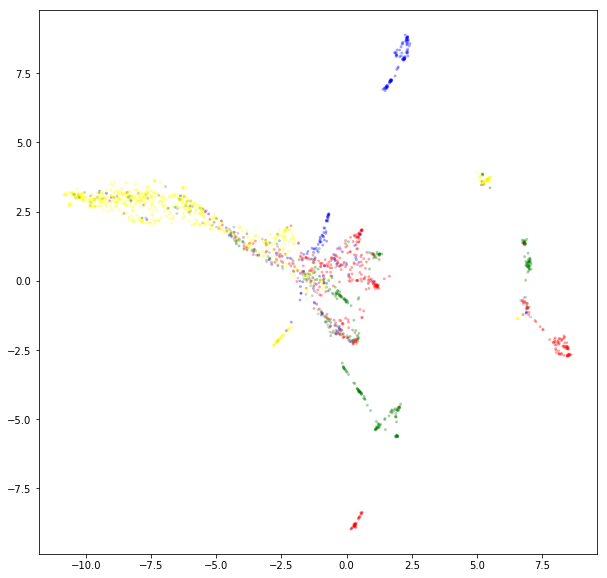

In [22]:
% matplotlib inline
import matplotlib.pyplot as plt

c = []
x = []
y = []
for i, item in enumerate(embedding):
    c.append(account_type_color_map[authors[i]['account_type'].lower()])
    x.append(item[0])
    y.append(item[1])

plt.figure(figsize=(10,10))
plt.scatter(x, y, c=c, s=4, alpha=0.25)
plt.show()

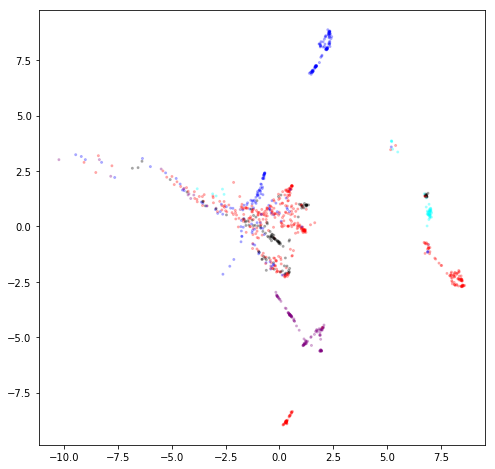

In [23]:
% matplotlib inline
import matplotlib.pyplot as plt

valid_account_types_color_map = {
    'lefttroll': 'blue',
    'righttroll': 'red',
    'hashtaggamer': 'purple',
    'fearmonger': 'black',
    'newsfeed': 'cyan'
}

c = []
x = []
y = []
for i, item in enumerate(embedding):
    try:
        valid_account_types_color_map[authors[i]['account_type'].lower()]
        c.append(valid_account_types_color_map[authors[i]['account_type'].lower()])
        x.append(item[0])
        y.append(item[1])
    except KeyError:
        pass

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=c, s=4, alpha=0.25)
plt.show()

In [95]:
from sklearn import cluster
n_clusters = 8
k_means = cluster.KMeans(n_clusters=n_clusters, random_state=42)
k_means.fit(docvecs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

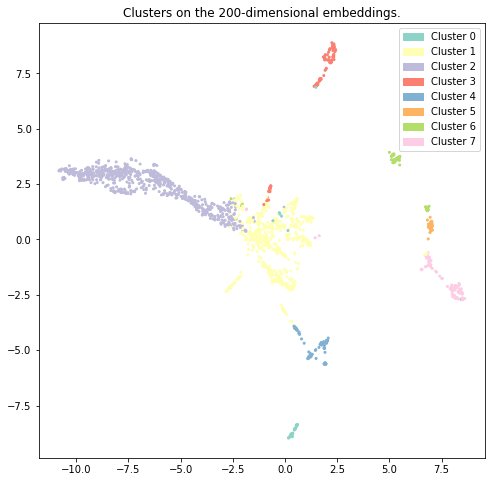

In [96]:
% matplotlib inline
from bokeh.palettes import Set3
import matplotlib.pyplot as plt
import matplotlib.patches as patches

c = []
x = []
y = []
for i, item in enumerate(embedding):
    try:
#         valid_account_types_color_map[authors[i]['account_type'].lower()]
        c.append(Set3[n_clusters][k_means.labels_[i]])
        x.append(item[0])
        y.append(item[1])
    except KeyError:
        pass

plt.figure(figsize=(8,8))
all_patches = []
for i in range(n_clusters):
    all_patches.append(patches.Patch(color=Set3[n_clusters][i], label='Cluster ' + str(i)))
plt.legend(handles=all_patches)
plt.scatter(x, y, c=c, s=4, alpha=1)
plt.title('Clusters on the 200-dimensional embeddings.')
plt.show()

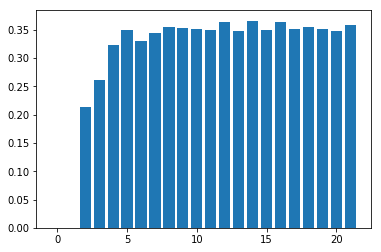

In [76]:
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cluster, metrics

ks = [0, 0]
rs = [0, 0]
for k in range(2, 22):
    ks.append(k)
    k_means_try = cluster.KMeans(n_clusters=k, random_state=42)
    k_means_try.fit(docvecs)
    labels_true = [ list(account_types.keys()).index(a['account_type'].lower()) for a in authors ]
    labels_predicted = [ l for l in k_means_try.labels_ ]
    rs.append(metrics.adjusted_rand_score(labels_true, labels_predicted))

plt.bar(ks, rs)
plt.show()


In [201]:
from minisom import MiniSom    
som = MiniSom(20, 20, 200, sigma=0.3, learning_rate=0.5, random_seed=42)
som.train_random(docvecs, 40000)

/Users/johnwest/Code/russian-troll-tweets-exploration/env/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


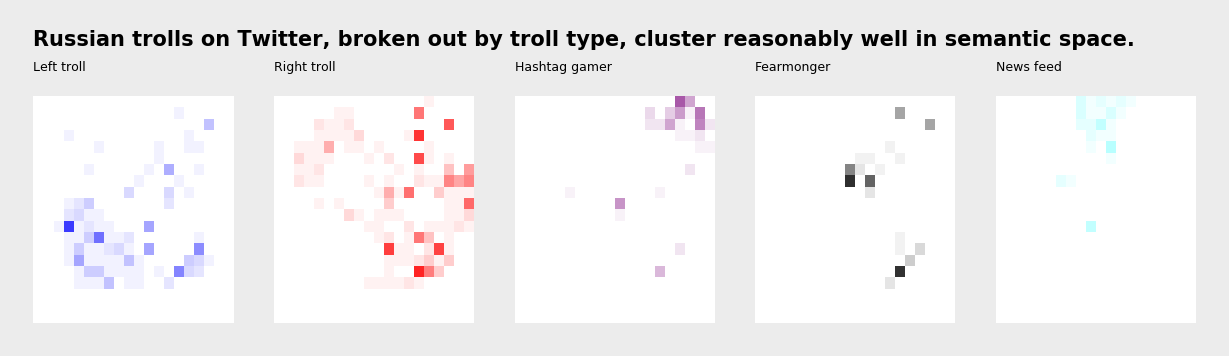

In [197]:
% matplotlib inline
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Droid Serif'

figure = plt.figure(figsize=(5,1), dpi=300, facecolor='#ececec')
figure.suptitle(
    'Russian trolls on Twitter, broken out by troll type, cluster reasonably well in semantic space.',
    fontsize=5,
    weight='bold',
    y=1.1,
    x=0.125,
    ha='left'
)

account_type_nice_name_map = {
    'lefttroll': 'Left troll',
    'righttroll': 'Right troll',
    'fearmonger': 'Fearmonger',
    'newsfeed': 'News feed',
    'hashtaggamer': 'Hashtag gamer'
}

subplot_i = 1
for account_type, color in valid_account_types_color_map.items():
    axes = figure.add_subplot(1, 5, subplot_i)
    plt.title(account_type_nice_name_map[account_type], fontsize=3, loc='left')
    axes.set_xlim([0, 20])
    axes.set_ylim([0, 20])
    patches_list = []
    c = []
    for i, docvec in enumerate(docvecs):
        if authors[i]['account_type'].lower() == account_type:
            c.append(valid_account_types_color_map[authors[i]['account_type'].lower()])
            winner = som.winner(docvec)
            rect = patches.Rectangle((winner[0], winner[1]), 1, 1)
            patches_list.append(rect)
    subplot_i += 1
    collection = PatchCollection(patches_list, alpha=0.05, color=c, edgecolor=None)
    axes.add_collection(collection)
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    axes.spines['bottom'].set_color(None)
    axes.spines['top'].set_color(None) 
    axes.spines['right'].set_color(None)
    axes.spines['left'].set_color(None)
plt.show()

/Users/johnwest/Code/russian-troll-tweets-exploration/env/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


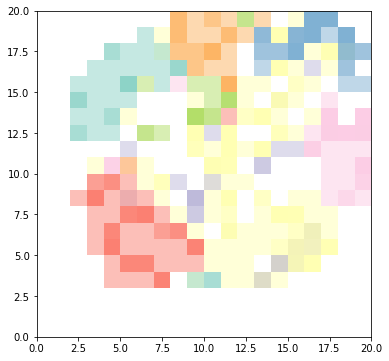

In [198]:
% matplotlib inline
from bokeh.palettes import Set3
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

figure = plt.figure(figsize=(6,6))
axes = figure.add_subplot(1, 1, 1)
axes.set_xlim([0, 20])
axes.set_ylim([0, 20])

patches_list = []
c = []
for i, docvec in enumerate(docvecs):
    try:
        valid_account_types_color_map[authors[i]['account_type'].lower()]
        c.append(Set3[n_clusters][k_means.labels_[i]])
        winner = som.winner(docvec)
        rect = patches.Rectangle((winner[0], winner[1]), 1, 1)
        patches_list.append(rect)
    except KeyError:
        pass

collection = PatchCollection(patches_list, alpha=0.5, color=c, edgecolor=None)
axes.add_collection(collection)
plt.show()

/Users/johnwest/Code/russian-troll-tweets-exploration/env/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


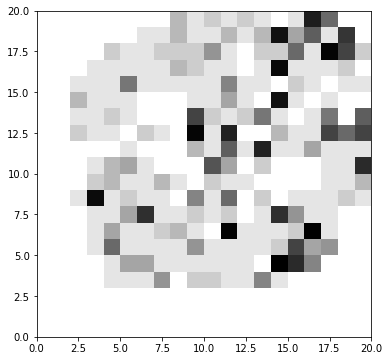

In [199]:
% matplotlib inline
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

figure = plt.figure(figsize=(6,6))
axes = figure.add_subplot(1, 1, 1)
axes.set_xlim([0, 20])
axes.set_ylim([0, 20])

patches_list = []
c = []
for i, docvec in enumerate(docvecs):
    try:
        valid_account_types_color_map[authors[i]['account_type'].lower()]
        c.append('black')
        winner = som.winner(docvec)
        rect = patches.Rectangle((winner[0], winner[1]), 1, 1)
        patches_list.append(rect)
    except KeyError:
        pass

collection = PatchCollection(patches_list, alpha=0.1, color=c, edgecolor=None)
axes.add_collection(collection)
plt.show()

In [200]:
import json

som_winners = []
for docvec in docvecs:
    som_winners.append([int(i) for i in list(som.winner(docvec))])

bare_authors = []
for author in authors:
    bare_authors.append({
        'account_type': author['account_type'],
        'external_author_id': author['external_author_id'],
        'tweets_count': author['tweets_count']
    })
    
out_data = {
    'account_types': account_types_meta,
    'authors': bare_authors,
    'clusters': k_means.labels_.tolist(),
    'som': som_winners,
    'umap': [[float(i) for i in x] for x in embedding.tolist()]
}

with open('./intermediate-data/english-only-doc2vec-data.json', 'w') as out_file:
    json.dump(out_data, out_file)
    


In [3]:
import json
with open('./intermediate-data/english-only-doc2vec-data.json', 'r') as in_file:
    data = json.load(in_file)

In [103]:
from tabletext import to_text

k_means_labels_map = {}
for label in k_means.labels_:
    try:
        k_means_labels_map[str(label)]
    except KeyError:
        k_means_labels_map[str(label)] = []

for i, author in enumerate(authors):
    k_means_labels_map[str(k_means.labels_[i])].append(author)

cluster_account_types = {}
table_data = [ ['c', 'size'] ]
for account_type in account_types:
    table_data[0].append(account_type)
for label, label_authors in k_means_labels_map.items():
    cluster_account_types[label] = {}
    for account_type in account_types:
        cluster_account_types[label][account_type] = []
    for author in label_authors:
        cluster_account_types[label][author['account_type'].lower()].append(author)
    table_datum = [ label, len(label_authors)]
    for account_type in account_types:
        table_datum.append(str(int(len(cluster_account_types[label][account_type]) / len(label_authors) * 100)) + '%')
    table_data.append(table_datum)
print(to_text(table_data))

┌───┬──────┬────────────┬────────────┬────────────┬───────────┬─────────┬──────────────┬──────────┬────────────┐
│ c │ size │ fearmonger │ righttroll │ nonenglish │ lefttroll │ unknown │ hashtaggamer │ newsfeed │ commercial │
├───┼──────┼────────────┼────────────┼────────────┼───────────┼─────────┼──────────────┼──────────┼────────────┤
│ 1 │  586 │ 16%        │ 42%        │ 14%        │ 13%       │ 10%     │ 3%           │ 0%       │ 0%         │
├───┼──────┼────────────┼────────────┼────────────┼───────────┼─────────┼──────────────┼──────────┼────────────┤
│ 2 │  693 │ 1%         │ 5%         │ 76%        │ 3%        │ 10%     │ 1%           │ 0%       │ 0%         │
├───┼──────┼────────────┼────────────┼────────────┼───────────┼─────────┼──────────────┼──────────┼────────────┤
│ 3 │  112 │ 0%         │ 0%         │ 0%         │ 100%      │ 0%      │ 0%           │ 0%       │ 0%         │
├───┼──────┼────────────┼────────────┼────────────┼───────────┼─────────┼──────────────┼────────

In [194]:
from gensim.utils import tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer

def get_top_terms_for_cluster(these_tweets_text):
    print('Vectorizing...')
    vectorizer = CountVectorizer(ngram_range=(1,1))
    vec = vectorizer.fit(these_tweets_text)
    bag_of_words = vec.transform(these_tweets_text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:100]

def get_tweets_text_for_cluster(cluster_key, secondary=False):
    these_tweets_text = []
    for account_type in cluster_account_types[cluster_key]:
        if account_type == 'lefttroll' or account_type == 'righttroll':
            for author in cluster_account_types[cluster_key][account_type]:
                tweets_text = ''
                for tweet_text in author['tweet_bodies']:
                    scrubbed_tweet_text = re.sub(r'\bhttps://t\.co/\S*\b', '', tweet_text)
                    tweets_text = tweets_text + ' ' + scrubbed_tweet_text
                these_tweets_text.append(tweets_text)
    if secondary != False:
        for account_type in cluster_account_types[secondary]:
            if account_type == 'lefttroll' or account_type == 'righttroll':
                for author in cluster_account_types[secondary][account_type]:
                    tweets_text = ''
                    for tweet_text in author['tweet_bodies']:
                        scrubbed_tweet_text = re.sub(r'\bhttps://t\.co/\S*\b', '', tweet_text)
                        tweets_text = tweets_text + ' ' + scrubbed_tweet_text
                    these_tweets_text.append(tweets_text)   
    return these_tweets_text

cluster_07_tweets_text = get_tweets_text_for_cluster('0', secondary='7')
cluster_1_tweets_text = get_tweets_text_for_cluster('1')
cluster_3_tweets_text = get_tweets_text_for_cluster('3')

cluster_07_top_terms = get_top_terms_for_cluster(cluster_07_tweets_text)
cluster_1_top_terms = get_top_terms_for_cluster(cluster_1_tweets_text)
cluster_3_top_terms = get_top_terms_for_cluster(cluster_3_tweets_text)


Vectorizing...
Vectorizing...
Vectorizing...


In [195]:
from tabletext import to_text

def get_unique_terms_for_cluster(cluster_terms, overlapping_terms):
    unique_terms = []
    for t in cluster_terms:
        if t[0] not in overlapping_terms:
            unique_terms.append(t[0])
    return unique_terms

bi_overlapping_terms = set([t[0] for t in cluster_07_top_terms]).intersection(set([t[0] for t in cluster_3_top_terms]))
tri_overlapping_terms = set(bi_overlapping_terms).intersection(set([t[0] for t in cluster_1_top_terms]))

table_data = [['cluster 3 (left)', 'cluster 0 & 7 (right)', 'cluster 1 (overlap)']]

cluster_3_unique_terms = get_unique_terms_for_cluster(cluster_3_top_terms, bi_overlapping_terms)
cluster_07_unique_terms = get_unique_terms_for_cluster(cluster_07_top_terms, bi_overlapping_terms)
cluster_1_unique_terms = get_unique_terms_for_cluster(cluster_1_top_terms, tri_overlapping_terms)

for i in range(10):
    table_data.append([
        cluster_3_unique_terms[i] if i < len(cluster_3_unique_terms) else '-',
        cluster_07_unique_terms[i] if i < len(cluster_07_unique_terms) else '-',
        cluster_1_unique_terms[i] if i < len(cluster_1_unique_terms) else '-'
    ])
print(to_text(table_data))

┌──────────────────┬───────────────────────┬─────────────────────┐
│ cluster 3 (left) │ cluster 0 & 7 (right) │ cluster 1 (overlap) │
├──────────────────┼───────────────────────┼─────────────────────┤
│ black            │ hillary               │ demndebate          │
├──────────────────┼───────────────────────┼─────────────────────┤
│ blacklivesmatter │ obama                 │ gopdebate           │
├──────────────────┼───────────────────────┼─────────────────────┤
│ white            │ tcot                  │ demdebate           │
├──────────────────┼───────────────────────┼─────────────────────┤
│ cops             │ clinton               │ islamkills          │
├──────────────────┼───────────────────────┼─────────────────────┤
│ here             │ pjnet                 │ stopthegop          │
├──────────────────┼───────────────────────┼─────────────────────┤
│ love             │ america               │ vegasgopdebate      │
├──────────────────┼───────────────────────┼──────────────────